In [480]:
import alpaca_trade_api as alpaca
from dotenv import load_dotenv
import os
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time
import datetime as dt

In [481]:
paper = True

# initialize API from API keys in .env
load_dotenv()

if paper:
    api_key = os.environ['APCA-API-PAPER-KEY-ID']
    api_secret_key = os.environ['APCA-API-PAPER-SECRET-KEY']
    api_base_url = 'https://paper-api.alpaca.markets'
else:
    api_key = os.environ['APCA-API-KEY-ID']
    api_secret_key = os.environ['APCA-API-SECRET-KEY']
    api_base_url = 'https://api.alpaca.markets'
print(api_key)
print(api_secret_key)

api = alpaca.REST(api_key, api_secret_key, api_base_url)
account = api.get_account()

PKNBD652OLGMWYB59QRI
H1xKfQ4ccH67Pi6mJrSaiX67iMrHopyYx9aANwbm


In [482]:
# history = api.get_portfolio_history(timeframe='1Min', period='7D')
# df = history.df
# df.to_csv('portfolio_history.csv')
# base_value = history.base_value - 70000
# df['equity'] = df['equity'] - 70000
# time.sleep(2)
# spy_df = api.get_bars('SPY', timeframe='1Min', start=df.iloc[0].name.astimezone(tz=None).strftime("%Y-%m-%dT%H:%M:%SZ")).df
# spy_df = spy_df.reset_index()
# spy_df['timestamp'] = spy_df['timestamp'].dt.tz_convert('EST')
# base_spy = spy_df.iloc[0]['open']
# spy_df['spy_equity'] = spy_df['open'] / base_spy * base_value
# # spy_df['spy_equity'] = 30000 + (spy_df['spy_equity'] - 100000) * 4 / 10
# spy_df = spy_df[['timestamp', 'spy_equity']]
# spy_df = spy_df.set_index('timestamp')
# df = df.join(spy_df)
# df = df.reset_index()
# plt.plot(df['equity'], label='algo')
# plt.plot(df['spy_equity'], label='SPY')
# plt.xticks([0, df.iloc[-1].name], labels=[df.iloc[0]['timestamp'], df.iloc[-1]['timestamp']])
# plt.legend()
# plt.show()
# df

In [ ]:
def plot_performance_vs_SPY(timeframe, period):
    minimum_equity = 50

    history = api.get_portfolio_history(timeframe=timeframe, period=period, extended_hours=False)
    df = history.df
    df = df[df['equity'] >= minimum_equity]
    # df['timestamp'] = df['timestamp'].dt.tz_convert('UTC')
    base_value = df.iloc[0]['equity']
    spy_df = api.get_bars('SPY', timeframe=timeframe, start=df.iloc[0].name.astimezone(tz=None).strftime("%Y-%m-%dT%H:%M:%SZ")).df
    spy_df = spy_df.reset_index()
    spy_df['timestamp'] = spy_df['timestamp'].dt.tz_convert('EST')
    base_spy = spy_df.iloc[0]['open']
    spy_df['spy_equity'] = spy_df['open'] / base_spy * base_value
    spy_df = spy_df[['timestamp', 'spy_equity']]
    spy_df = spy_df.set_index('timestamp')
    df = df.join(spy_df)
    df['percent gain'] = 100 * df['equity'] / base_value - 100
    df['SPY percent gain'] = 100 * df['spy_equity'] / base_value - 100
    df = df.reset_index()
    fig, ax1 = plt.subplots()
    ax1.plot(df['equity'], label='algo')
    ax1.plot(df['spy_equity'], label='SPY')
    ax1.set_ylabel('equity')
    plt.legend()
    ax2 = ax1.twinx()
    mn, mx = ax1.get_ylim()
    ax2.set_ylim(100 * mn / base_value - 100, 100 * mx / base_value - 100)
    ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax2.set_ylabel('percent gain')

    
    # plt.plot(df['equity'], label='algo')
    # plt.plot(df['spy_equity'], label='SPY')
    plt.xticks([0, df.iloc[-1].name], labels=[df.iloc[0]['timestamp'], df.iloc[-1]['timestamp']])
    
    plt.show()
    df

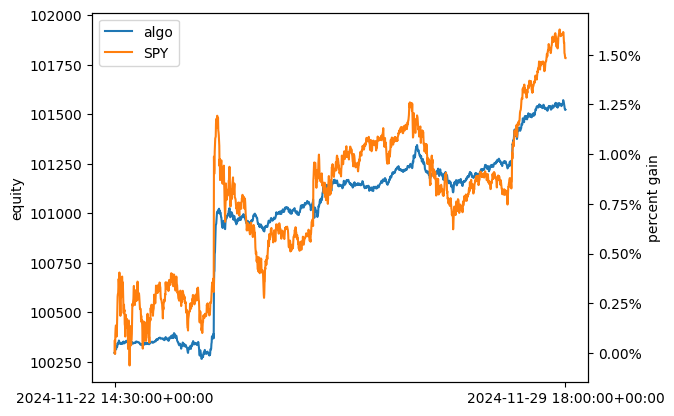

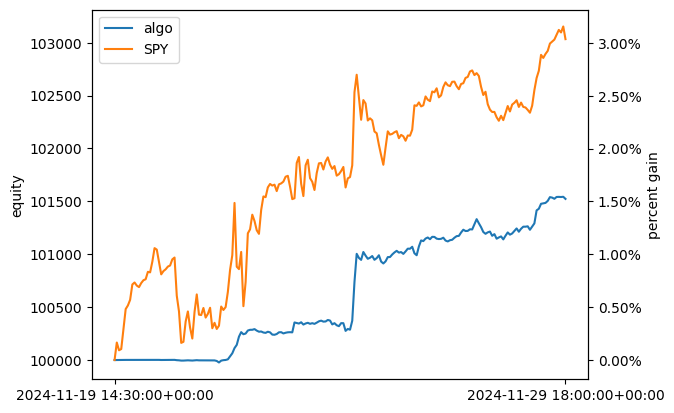

In [484]:
plot_performance_vs_SPY('1Min', '7D')
plot_performance_vs_SPY('15Min', '30D')
# plot_performance_vs_SPY('1D', '6M')